In this module, we aim to create predictive models that can be used to accurately predict the Under-Five Mortality Rate (U5MR) in select Indian states using the features we identified earlier from the Annual Health Survey.

In [1]:
#Start by importing all necessary libraries and modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from time import time
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, KFold, learning_curve, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score

In [2]:
#We load our predictor and target variable training and test subsets.
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)
data_std = pd.read_csv('data_std.csv', index_col=0)
# Set the max columns and rows to 'None' so that we can see all rows and columns.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
#We will do K-Fold cross validation with 10 splits or iterations.
kfold = KFold(n_splits=10)

In [4]:
#These are the regressors that we will initially consider as possibilities from which to make models.
regressors = [
    GradientBoostingRegressor(),
    RandomForestRegressor(),
    KNeighborsRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge(),
    SVR()
]

Gradient Boosting Regressor is a model that adds multiple simple decision trees, one at a time, strengthening the predictions.

Random Forest Regressor fits multiple decision trees onto the dataset or a subset of the dataset at once and averages their predictions.

K-Neighbors Regressor predicts continuous values based on distance from other samples.

Linear Regression is a relatively simple method that creates a line that will minimize the distance from samples in order to predict a continuous target.

Lasso is a method of regularization used to combat overfitting by shrinking data coefficients, sometimes to 0, which drops them.

Ridge is a method of regularization used to combat overfitting by shrinking data coefficients; it can make them approach, but not become, 0.

Support Vector Regression creates a hyperplane as a regression line that has an equal threshold on each side within which data points will not be penalized for their error.

Through 10-fold cross-validation, we will fit the possible regressors to the training subsets and predict values on the test subset. For each regressor, we will get the training and prediction times just for our knowledge and the explained variance, mean squared error and R2. Although MSE and R2 are good metrics to evaluate models, for initially selecting the models to work with, we will see which models have the highest explained variance (variation in target that is determined by other features).

In [5]:
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train.values.ravel())
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean squared error:", mean_squared_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()


#We can see that KNeighbors, Lasso and SVR are not good, so let us not use those.
#We will proceed with GradientBoostingRegressor, RandomForestRegressor, LinearRegression and Ridge.

GradientBoostingRegressor()
	Training time: 0.331s
	Prediction time: 0.000s
	Explained variance: 0.865678282892097
	Mean squared error: 0.12942188915191719
	R2 score: 0.8653568933763143

RandomForestRegressor()
	Training time: 0.480s
	Prediction time: 0.010s
	Explained variance: 0.8708353722533417
	Mean squared error: 0.12451502723105039
	R2 score: 0.8704617109394659

KNeighborsRegressor()
	Training time: 0.006s
	Prediction time: 0.154s
	Explained variance: 0.7243241266546805
	Mean squared error: 0.2719419296741321
	R2 score: 0.7170872217018429

LinearRegression()
	Training time: 0.040s
	Prediction time: 0.000s
	Explained variance: 0.9071032845758618
	Mean squared error: 0.09081917844915156
	R2 score: 0.9055169383824165

Lasso()
	Training time: 0.005s
	Prediction time: 0.005s
	Explained variance: 0.0
	Mean squared error: 0.9612218203643907
	R2 score: -2.2379666564376066e-08

Ridge()
	Training time: 0.007s
	Prediction time: 0.008s
	Explained variance: 0.9121703497360082
	Mean squared er

In [6]:
#Linear Regression 
LR = LinearRegression()


## Search grid for optimal hyperparameters
lr_param_grid = {"fit_intercept": [True, False]}

gsLR = GridSearchCV(LR,param_grid = lr_param_grid, cv=kfold, scoring="explained_variance", n_jobs= -1, verbose = 1)


#Fit the best hyperparameters to the training data points
gsLR.fit(X_train,y_train.values.ravel())

#Define best version of the model to be used later
LR_best = gsLR.best_estimator_

# Score using the best hyperparameters
gsLR.best_score_

Fitting 10 folds for each of 2 candidates, totalling 20 fits


0.8709741892937275

In [7]:
#Ridge
ridge = Ridge()


ridge_param_grid = {'solver':['svd', 'cholesky', 'lsqr', 'sag'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'fit_intercept':[True, False]}

gsRidge = GridSearchCV(ridge,param_grid = ridge_param_grid, cv=kfold, scoring="explained_variance", n_jobs= -1, verbose = 1)

gsRidge.fit(X_train,y_train.values.ravel())

Ridge_best = gsRidge.best_estimator_

gsRidge.best_score_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


0.8712674702994114

In [8]:
#Gradient Boosting Regressor 
GBR = GradientBoostingRegressor()


gbr_param_grid = {"learning_rate": [0.01, 0.1],
                  "subsample": [0.9, 0.5, 0.1],
                  "n_estimators": [100,500,1000],
                  "max_depth": [3,6,10],
                 "loss": ["squared_error"]}


gsGBR = GridSearchCV(GBR,param_grid = gbr_param_grid, cv=kfold, scoring="explained_variance", n_jobs= -1, verbose = 1)

gsGBR.fit(X_train,y_train.values.ravel())

GBR_best = gsGBR.best_estimator_

gsGBR.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8878076618547788

In [9]:
#Random Forest Regressor
RFR = RandomForestRegressor()


rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10, 20],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100],
              "criterion": ["squared_error"]}


gsRFR = GridSearchCV(RFR,param_grid = rf_param_grid, cv=kfold, scoring="explained_variance", n_jobs= -1, verbose = 1)

gsRFR.fit(X_train,y_train.values.ravel())

RFR_best = gsRFR.best_estimator_

gsRFR.best_score_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


0.8706204877154153

We will perform Principal Components Analysis, which can be useful in problems with many predictor variables. It compresses the information provided by all predictor variables into a smaller number of principal components, reducing dimensionality. We will create each type of model once using all predictors and a second time using a chosen number of principal components.

In [10]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
pca.explained_variance_ratio_
#We now have 32 principal components, one for each predictor in the dataset.

array([3.66911262e-01, 1.54925429e-01, 1.02522520e-01, 8.08438787e-02,
       5.01258603e-02, 4.35833016e-02, 3.26522587e-02, 3.10984922e-02,
       2.59081001e-02, 2.13411247e-02, 1.50272837e-02, 1.47732957e-02,
       1.13905989e-02, 1.04727167e-02, 8.09359588e-03, 5.49269141e-03,
       4.67116711e-03, 4.30186278e-03, 3.49511258e-03, 3.00857675e-03,
       2.18115222e-03, 1.97772707e-03, 1.67018559e-03, 1.31183317e-03,
       9.47250144e-04, 7.26642677e-04, 2.23166154e-04, 1.25137610e-04,
       9.01510433e-05, 7.09622460e-05, 2.66078251e-05, 1.00563182e-05])

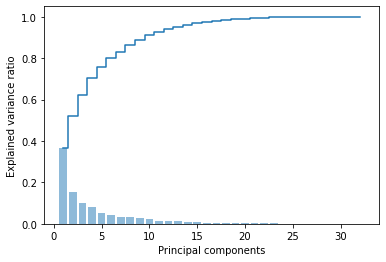

In [11]:
plt.bar(range(1, 33), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 33), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [12]:
pca = PCA(n_components=6) #Top six principal components encapsulate approximately 80% of variation
#So let us limit it to six components and re-fit the training and test features.
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
#Now, we can use these to generate PCA versions of our models.

Linear Regression

In [13]:
#Define the model
model = LinearRegression()

#Perform the grid search to find the best hyperparameters and use them to fit the model
rs = RandomizedSearchCV(model, n_iter=10,
                        param_distributions = {"fit_intercept": [True, False]},
                        cv=5, n_jobs=-1, random_state=3,
                        scoring='explained_variance')

rs.fit(X_train, y_train.values.ravel())

print(rs.best_params_)
print(rs.best_score_)

{'fit_intercept': False}
0.8772246378009056


C:\Users\dralu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [14]:
#Rebuild with ideal hyperparameters
lr = LinearRegression(fit_intercept=False)

#Fit (train) the model
lr.fit(X_train, y_train.values.ravel())

LinearRegression(fit_intercept=False)

In [15]:
#We predict the target values on the training and test values
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [16]:
print(list(zip(lr.coef_, X_train.columns)))

#Here, we have the coefficients of each variable used to create the linear model, ordered by their order in the dataset.
#These quantify the amount of influence each variable has on the prediction.
#The larger the absolute value of the coefficient, the greater its impact.

[(0.003081297775667912, 'AA_Population_Total'), (-0.06435783369143695, 'BB_Dependency_Ratio_Rural'), (0.263102644996433, 'BB_Dependency_Ratio_Total'), (-0.053300342714453906, 'BB_Dependency_Ratio_Urban'), (-1.7776263172491693, 'DD_Female_Total'), (-1.4662337560412724, 'DD_Male_Total'), (-0.1433945483258997, 'DD_Person_Rural'), (3.2519040274720092, 'DD_Person_Total'), (0.010306331874220417, 'DD_Person_Urban'), (-0.023017053928499658, 'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Rural'), (0.11203295265521554, 'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Total'), (0.04793637495552373, 'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Urban'), (0.1601992164904011, 'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Rural'), (-0.09138135272682729, 'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Total'), (0.0027240921066952204, 'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Urban'), (0.06585575914489383, 'LL_Crude_Birth_Rate_Cbr_Total'),

C:\Users\dralu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

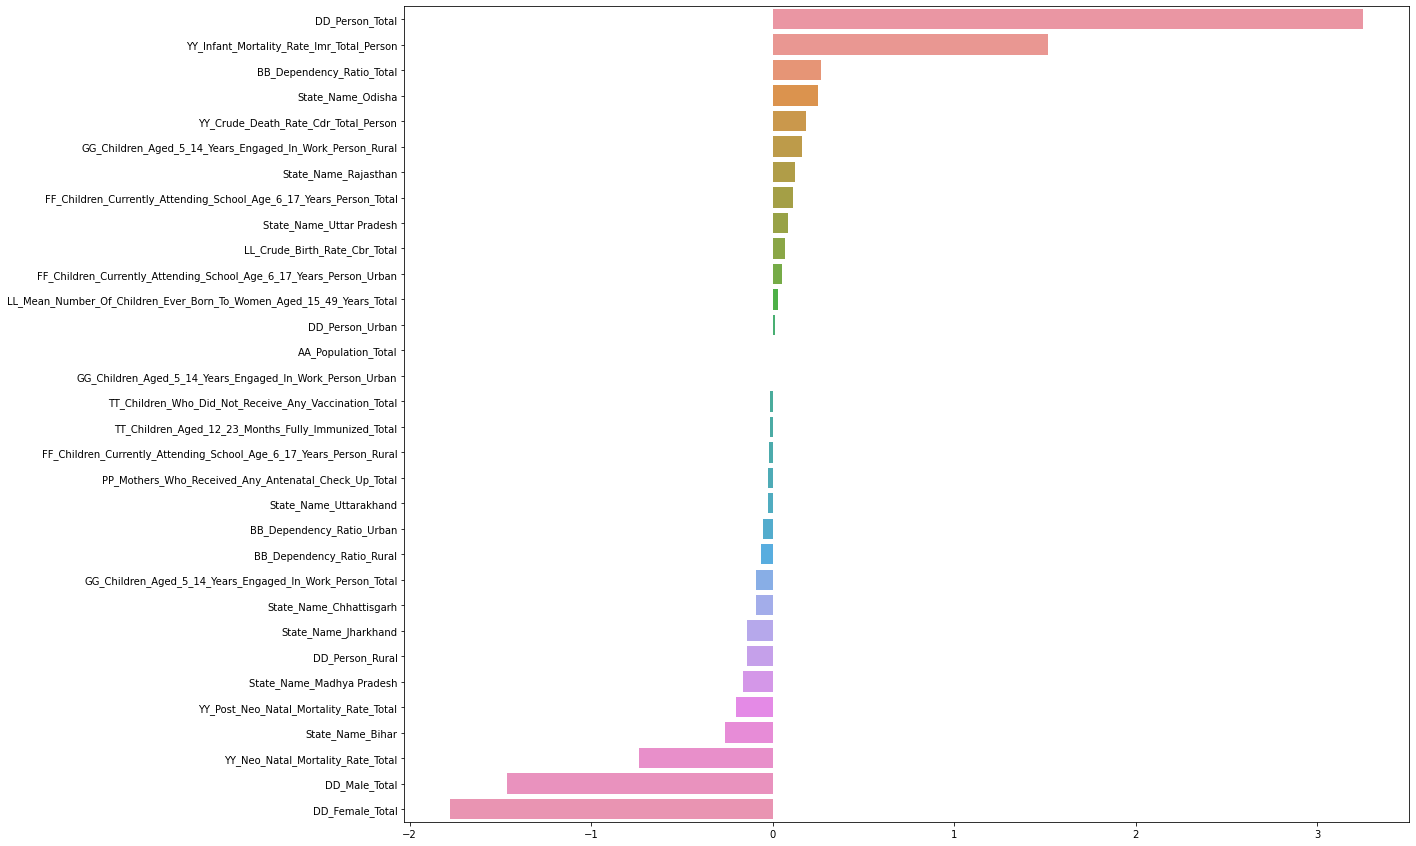

In [17]:
sorted_indices = lr.coef_.argsort()[::-1]
sorted_feature_names = X_train.columns[sorted_indices]
sorted_importances = lr.coef_[sorted_indices]

plt.figure(figsize=(18, 15))
sns.barplot(sorted_importances, sorted_feature_names)

Here, we show the 32 features of the dataset ordered by coefficient, from greatest to least. The importance of education in combatting under-five mortality is shown by the fact that the greatest two coefficients are those belonging to total literacy and female literacy; they are followed by total infant mortality and male literacy, but the former adds little to our understanding of the causes of under-five mortality. It is also interesting and suprising to see that total literacy has a positive coefficient, meaning that greater total literacy rates correlate to a greater U5MR. Female and male literacy, on the other hand, are negatively correlated, so an increase in them would correlate to a lower U5MR. It might be worthwhile to explore this paradox in further analyses.

In [18]:
#Mean squared error (MSE) is a metric to evaluate the fit of a regression model (compares predicted to actual values).
#MSE penalizes large errors more than mean absolute error does because it squares the errors.


#Get training score for model with idealized hyperparameters
print('Train mean squared error: %.3f' % mean_squared_error(y_true=y_train, y_pred=y_train_pred))

#Let us test the model that has idealized hyperparameters.
print('Test mean squared error: %.3f' % mean_squared_error(y_true=y_test, y_pred=y_test_pred))

#Test MSE is slightly higher than train MSE here, which is indicates overfitting. Ideally, test error will be lower.
#A higher test MSE means that the model did not generalize well to unseen data.

Train mean squared error: 0.085
Test mean squared error: 0.092


A residual plot shows the difference between predicted and actual values. The closer to the black line the points are, the less error there is. Here, we have a residual plot for the training and test data. In a residual plot, we want to see two things:
1. Concentration of points near the black horizontal line
2. No bias or patterns. If we see that, it may indicate that a linear model is not the best choice.

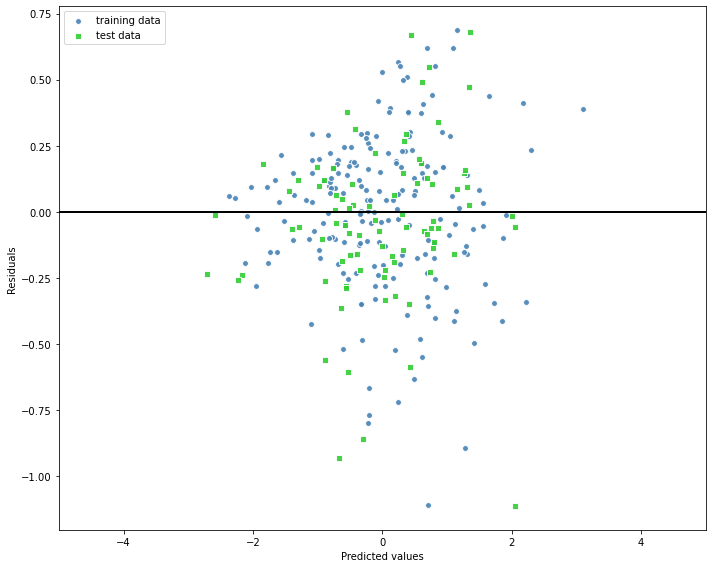

In [19]:
y_train_pred=y_train_pred.reshape(198,1)
y_test_pred=y_test_pred.reshape(86,1)

fig = plt.figure(figsize=(10, 8))

plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-5, 5])
plt.tight_layout()

plt.show()


#The second point (no bias or patterns) is satisfied, but not the first (concentration of points near black line).
#So, we can understand from this that a linear model is not necessarily a bad choice, but there was a lot of error.
#However, the green and blue points are interspersed, which again shows that there was not
#a huge amount of difference between the errors of the training and test subsets. This is good.

<AxesSubplot:ylabel='Count'>

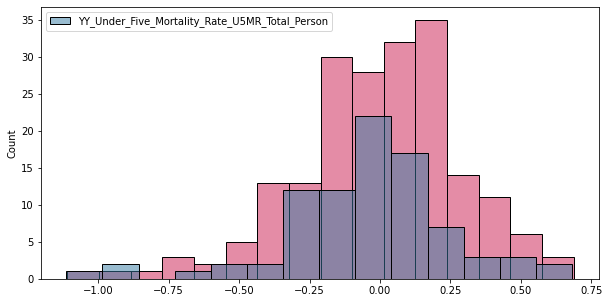

In [20]:
fig = plt.figure(figsize=(10, 5))

sns.histplot(y_train_pred-y_train, palette="rocket")
sns.histplot(y_test_pred-y_test, palette="mako")
#Shows counts of samples [districts] for each amount of difference between predicted and actual value.
#Both the train (pink) and test (blue) subsets primarily have low differences.

In [21]:
#Coefficient of determination (R squared) is somewhat similar to explained variance.
# It indicates how much variation in the target variable can be predicted from the predictor variables.

print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

#Here, the test R2 is somewhat lower than the train R2, which indicates overfitting. Ideally, test R2 will be higher,
#because it means that the model could be generalized to unseen test data.

R^2 train: 0.916, test: 0.905


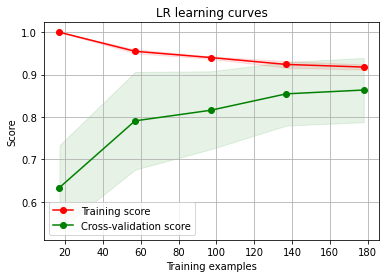

In [22]:
#Let us see a learning curve to check the overfitting.
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsLR.best_estimator_,"LR learning curves", X_train, y_train, cv=kfold)

The learning curve shows that the training score and the cross-validated test score approach each other as more samples are added. This is good, as is means that there is not too much overfitting. The scores do not seem to level off by the end of the graph, unsurprising given the low sample size in the dataset. This indicates that the addition of more samples would likely be beneficial in creating a more effective predictive model. However, there may be some real-life constraints to this, given the scope of the survey from which these data are taken.

The basic linear regression model shows slight overfitting through its MSE and R2 scores, but is still good overall.

Linear Regression with PCA

In [23]:
#We need to do this part again so that we can use it in a learning curve later.
#The grid search is the same and not dependent on the data used, so there is no need to redo it.

#Here, we are fitting the same model, but using the first six principal components, not all 32 features.
gsLR.fit(X_train_pca,y_train.values.ravel())

LR_best_pca = gsLR.best_estimator_

gsLR.best_score_

Fitting 10 folds for each of 2 candidates, totalling 20 fits


0.8393404728160514

In [24]:
rs_pca = RandomizedSearchCV(model, n_iter=10,
                        param_distributions = {"fit_intercept": [True, False]},
                        cv=5, n_jobs=-1, random_state=3,
                        scoring='explained_variance')

rs_pca.fit(X_train_pca, y_train.values.ravel())

print(rs.best_params_)
print(rs.best_score_)

{'fit_intercept': False}
0.8772246378009056


C:\Users\dralu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [25]:
lr_pca = LinearRegression(fit_intercept=False)

lr_pca.fit(X_train_pca, y_train.values.ravel())

LinearRegression(fit_intercept=False)

In [26]:
y_train_pred = lr_pca.predict(X_train_pca)
y_test_pred = lr_pca.predict(X_test_pca)

In [27]:
print(list(zip(lr_pca.coef_, pca.components_)))

[(0.22332559059638343, array([-0.12092586,  0.23589636,  0.24414177,  0.1952839 , -0.28294407,
       -0.27599034, -0.26700291, -0.28790038, -0.24896063, -0.12834882,
       -0.13972701, -0.10132941,  0.13395978,  0.14528611,  0.10075802,
        0.24343827,  0.22471701, -0.23696114, -0.19746042,  0.22679493,
        0.11645935,  0.19498251,  0.1778735 ,  0.14078899,  0.02263532,
       -0.01745975, -0.00602909, -0.00903027, -0.0183463 ,  0.01199843,
        0.05445957, -0.01928863])), (-0.2001536567145734, array([ 0.15590994,  0.27379634,  0.27439601,  0.27714915, -0.09806938,
       -0.07040997, -0.07766804, -0.09129401, -0.11039057,  0.3329423 ,
        0.33458104,  0.28482048, -0.19049194, -0.20009364, -0.21562418,
        0.07852223,  0.1243702 , -0.12990005,  0.14675492, -0.01264384,
       -0.2127575 , -0.25355369, -0.22794742, -0.18622199,  0.12326305,
        0.00549506,  0.03413856, -0.03598613, -0.06508504, -0.0058534 ,
       -0.04545188,  0.01842254])), (-0.272975841203687

Here, we have a list of the six principal components with the highest explained variance with which we chose to do our PCA modelling, represented by their eigenvalues. The eigenvalues represent the total amount of variance that each component explains. In theory, they can be positive or negative; however, since variance cannot be negative, the presence of negative eigenvalues, as we see here, implies that the model is not good. A possible explanation for the negative eigenvalues is that there are too many highly correlated variables in the dataset.

Each principal component has one eigenvector (coefficient) for each of the original 32 features which are listed as an array following each component's respective eigenvalue. The larger the absolute value of the coefficient, the greater its impact in creating the component. One problem with using PCA to generate predictive models is that it can be somewhat of a black box. It is more difficult to interpret the meaning of the eigenvectors and eigenvalues as they relate to real-life factors.

In [28]:
print('Train mean squared error: %.3f' % mean_squared_error(y_true=y_train, y_pred=y_train_pred))

print('Test mean squared error: %.3f' % mean_squared_error(y_true=y_test, y_pred=y_test_pred))

#The test MSE is very slightly lower than the train MSE, which is good.
#On the negative side, the MSE values are higher (worse) than those from the non-PCA linear regression model.

Train mean squared error: 0.143
Test mean squared error: 0.141


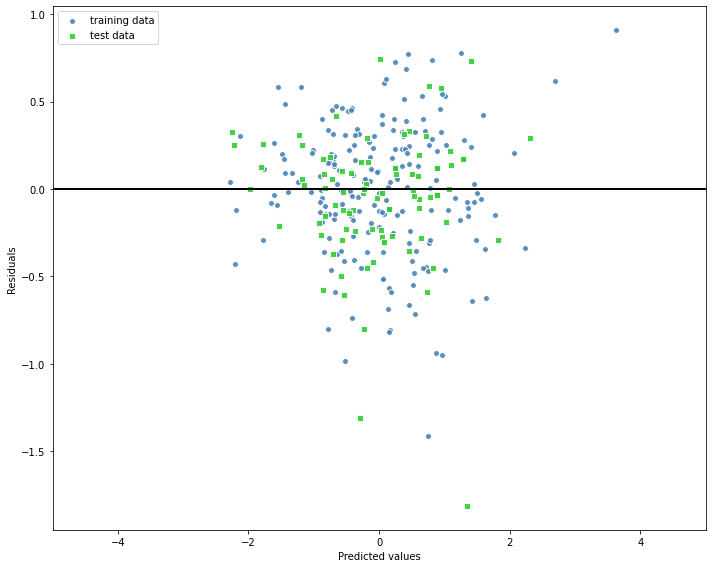

In [29]:
y_train_pred=y_train_pred.reshape(198,1)
y_test_pred=y_test_pred.reshape(86,1)

fig = plt.figure(figsize=(10, 8))

plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-5, 5])
plt.tight_layout()

plt.show()


#Here, we do not see a pattern, which is good.
#However, most points are not near the black line, and some appear to be farther from the black line
#than those in the non-PCA linear regression residual plot.

<AxesSubplot:ylabel='Count'>

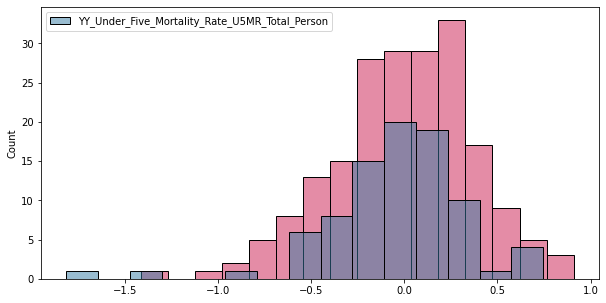

In [30]:
fig = plt.figure(figsize=(10, 5))

sns.histplot(y_train_pred-y_train, palette="rocket")
sns.histplot(y_test_pred-y_test, palette="mako")

#Both plots show that most predicted values were not far from the actual values, which is good.

In [31]:
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

#Train R2 is very slightly higher than test R2, which is not ideal, but it is not by a large amount.
#On the negative side, the R2 values are lower (worse) than those from the non-PCA linear regression model.

R^2 train: 0.858, test: 0.854


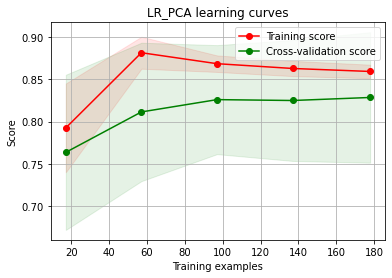

In [32]:
g = plot_learning_curve(gsLR.best_estimator_,"LR_PCA learning curves", X_train_pca, y_train, cv=kfold)

#Here, in a contrast to the model which utilized all features, training score is initially somewhat low.
#However, it remains higher than the cross-validation score throughout the curve.
#Eventually, they approach each other, which is a positive sign.

Linear regression with PCA shows slight overfitting in its R2 value, and fares worse on MSE and R2 than the basic linear regression model.

Ridge Regression

In [33]:
model = Ridge()
rs = RandomizedSearchCV(model, n_iter=10,
                        param_distributions = {'solver':['svd', 'cholesky', 'lsqr', 'sag'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'fit_intercept':[True, False]},
                        cv=5, n_jobs=-1, random_state=3,
                        scoring='explained_variance') 

rs.fit(X_train, y_train.values.ravel())

print(rs.best_params_)
print(rs.best_score_)

{'solver': 'sag', 'fit_intercept': False, 'alpha': 10}
0.8773565309925685


In [34]:
ridge = Ridge(solver='sag', fit_intercept=False, alpha=10, random_state=3)

ridge.fit(X_train, y_train.values.ravel())

Ridge(alpha=10, fit_intercept=False, random_state=3, solver='sag')

In [35]:
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

In [36]:
print(list(zip(ridge.coef_, X_train.columns)))

[(-0.01660157704596714, 'AA_Population_Total'), (0.02931526011610768, 'BB_Dependency_Ratio_Rural'), (-0.0009651630046164301, 'BB_Dependency_Ratio_Total'), (-0.005278837539080984, 'BB_Dependency_Ratio_Urban'), (-0.002410350461382158, 'DD_Female_Total'), (-0.0822033614853425, 'DD_Male_Total'), (-0.01388077037889066, 'DD_Person_Rural'), (0.037530786593695964, 'DD_Person_Total'), (0.022362551963832918, 'DD_Person_Urban'), (0.009394759379646995, 'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Rural'), (0.012890301214419185, 'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Total'), (0.0461494858730362, 'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Urban'), (0.03653930720828193, 'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Rural'), (0.02058812226889795, 'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Total'), (-0.0030940412827901637, 'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Urban'), (0.09458925848807136, 'LL_Crude_Birth_Rate_Cbr

C:\Users\dralu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

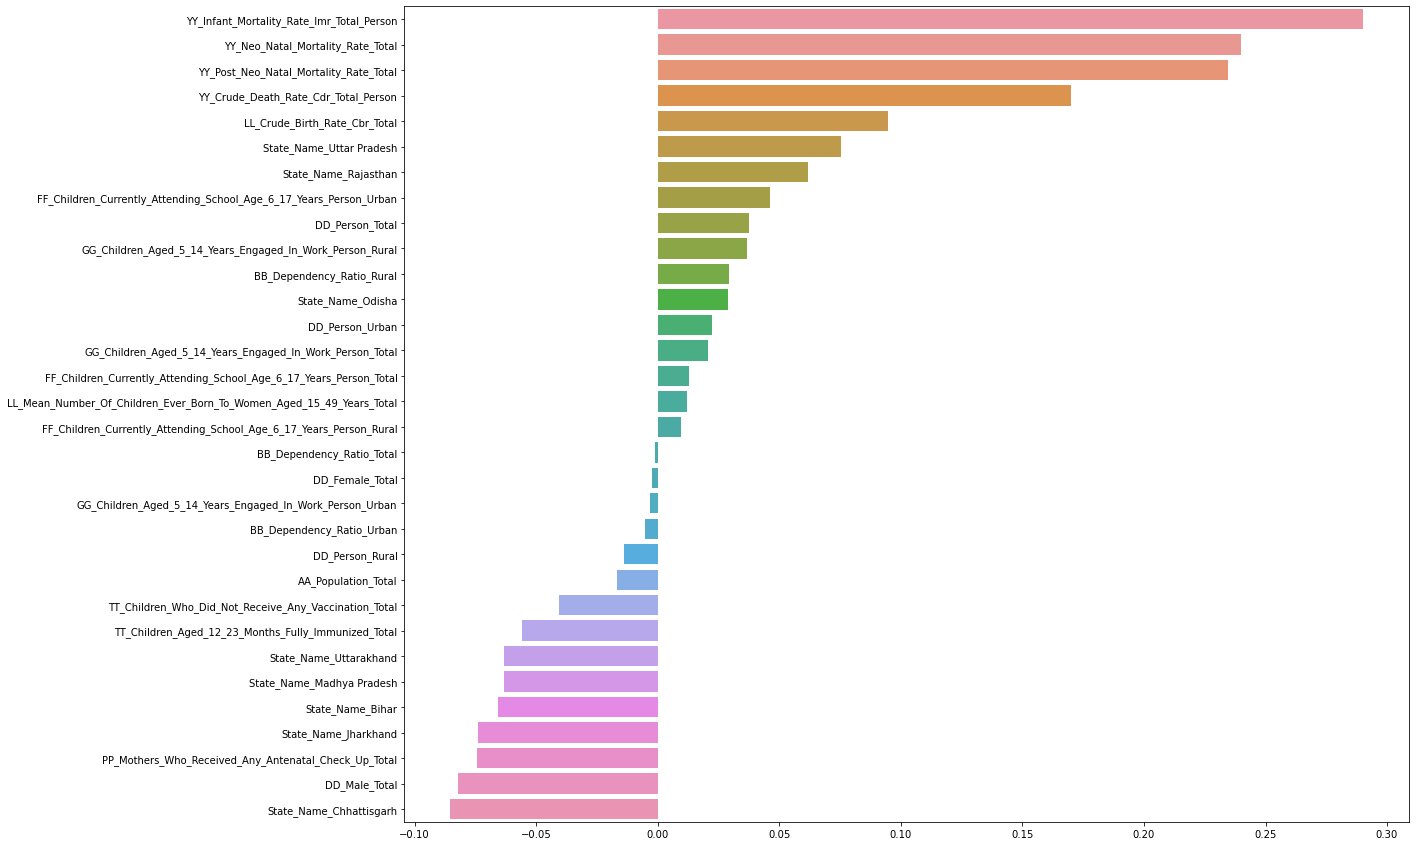

In [37]:
sorted_indices = ridge.coef_.argsort()[::-1]
sorted_feature_names = X_train.columns[sorted_indices]
sorted_importances = ridge.coef_[sorted_indices]

plt.figure(figsize=(18, 15))
sns.barplot(sorted_importances, sorted_feature_names)

Our Ridge model shows very different feature importances than our Linear Regression model. We see that the four most important features, which have the greatest effect on the predictive model, are the four that also are related to mortality/death rates. We had anticipated prior to modeling that these would be closely correlated to the target. They are followed in positive and negative magnitude by a mix of features related to birth rate, state, education and healthcare. The fact that most of the states have relatively larger coefficients suggests that differences among the nine states surveyed may play a large role in their respective Under-Five Mortality Rates, particularly the fact that some states have a much higher rate than others.

In [38]:
print('Train mean squared error: %.3f' % mean_squared_error(y_true=y_train, y_pred=y_train_pred))

print('Test mean squared error: %.3f' % mean_squared_error(y_true=y_test, y_pred=y_test_pred))

#Test MSE is lower than train MSE. This is good.

Train mean squared error: 0.099
Test mean squared error: 0.090


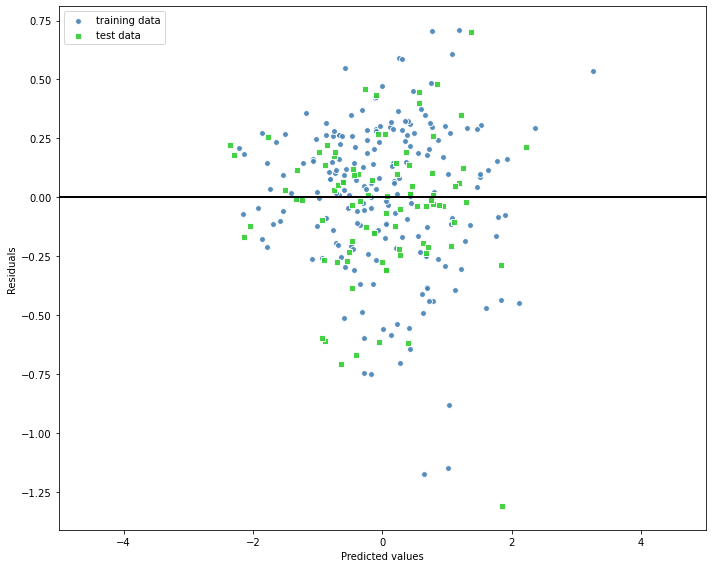

In [39]:
y_train_pred=y_train_pred.reshape(198,1)
y_test_pred=y_test_pred.reshape(86,1)

fig = plt.figure(figsize=(10, 8))

plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-5, 5])
plt.tight_layout()

plt.show()

#Although most points are not near the black line, the training and test residuals are interspersed
# and no pattern is to be found. This is good.

<AxesSubplot:ylabel='Count'>

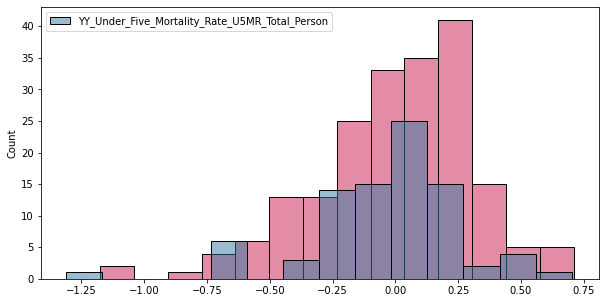

In [40]:
fig = plt.figure(figsize=(10, 5))

sns.histplot(y_train_pred-y_train, palette="rocket")
sns.histplot(y_test_pred-y_test, palette="mako")

#Again, most samples' error was not very large. There appears to be a right skew.

In [41]:
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

#Test R2 is slightly higher than train R2, which is also good.

R^2 train: 0.902, test: 0.906


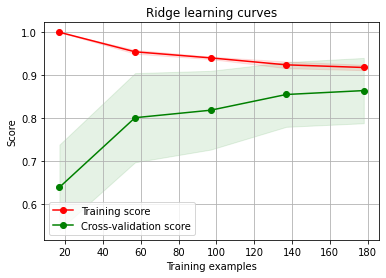

In [42]:
g = plot_learning_curve(gsRidge.best_estimator_,"Ridge learning curves", X_train, y_train, cv=kfold)

#The scores approach each other and would likely continue to do so if more training samples were provided. This is good.

This model appears to be the best of the eight created, based on the MSE, R2 and learning curve.

Ridge Regression with PCA

In [43]:
gsRidge.fit(X_train_pca,y_train.values.ravel())

Ridge_best_pca = gsRidge.best_estimator_

gsRidge.best_score_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


0.8398802302299199

In [44]:
rs_pca = RandomizedSearchCV(model, n_iter=10,
                        param_distributions = {'solver':['svd', 'cholesky', 'lsqr', 'sag'],
                        'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
                        'fit_intercept':[True, False]},
                        cv=5, n_jobs=-1, random_state=3,
                        scoring='explained_variance')

rs_pca.fit(X_train_pca, y_train.values.ravel())

print(rs.best_params_)
print(rs.best_score_)

{'solver': 'sag', 'fit_intercept': False, 'alpha': 10}
0.8773565309925685


In [45]:
ridge_pca = Ridge(solver='sag', fit_intercept=False, alpha=10, random_state=3)

ridge_pca.fit(X_train_pca, y_train.values.ravel())

Ridge(alpha=10, fit_intercept=False, random_state=3, solver='sag')

In [46]:
y_train_pred = ridge_pca.predict(X_train_pca)
y_test_pred = ridge_pca.predict(X_test_pca)

In [47]:
print(list(zip(ridge_pca.coef_, pca.components_)))

#Some of the eigenvalues are again negative, which is not ideal,
#but may be explained by the composition of the original data set.

[(0.22208807433980424, array([-0.12092586,  0.23589636,  0.24414177,  0.1952839 , -0.28294407,
       -0.27599034, -0.26700291, -0.28790038, -0.24896063, -0.12834882,
       -0.13972701, -0.10132941,  0.13395978,  0.14528611,  0.10075802,
        0.24343827,  0.22471701, -0.23696114, -0.19746042,  0.22679493,
        0.11645935,  0.19498251,  0.1778735 ,  0.14078899,  0.02263532,
       -0.01745975, -0.00602909, -0.00903027, -0.0183463 ,  0.01199843,
        0.05445957, -0.01928863])), (-0.1975495568441371, array([ 0.15590994,  0.27379634,  0.27439601,  0.27714915, -0.09806938,
       -0.07040997, -0.07766804, -0.09129401, -0.11039057,  0.3329423 ,
        0.33458104,  0.28482048, -0.19049194, -0.20009364, -0.21562418,
        0.07852223,  0.1243702 , -0.12990005,  0.14675492, -0.01264384,
       -0.2127575 , -0.25355369, -0.22794742, -0.18622199,  0.12326305,
        0.00549506,  0.03413856, -0.03598613, -0.06508504, -0.0058534 ,
       -0.04545188,  0.01842254])), (-0.267665493029191

In [48]:
print('Train mean squared error: %.3f' % mean_squared_error(y_true=y_train, y_pred=y_train_pred))

print('Test mean squared error: %.3f' % mean_squared_error(y_true=y_test, y_pred=y_test_pred))

#Test MSE is slightly lower than train MSE, which is good.

Train mean squared error: 0.144
Test mean squared error: 0.142


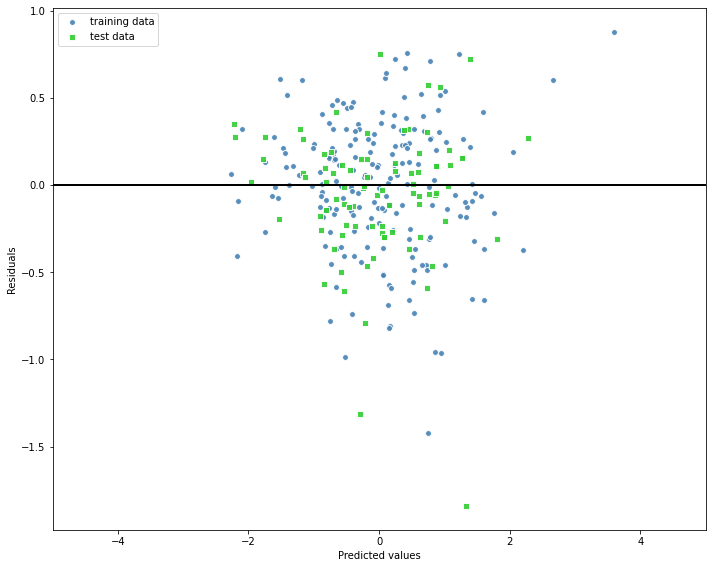

In [49]:
y_train_pred=y_train_pred.reshape(198,1)
y_test_pred=y_test_pred.reshape(86,1)

fig = plt.figure(figsize=(10, 8))

plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-5, 5])
plt.tight_layout()

plt.show()

#This is similar to the basic Ridge residual plot, although the residuals are greater.

<AxesSubplot:ylabel='Count'>

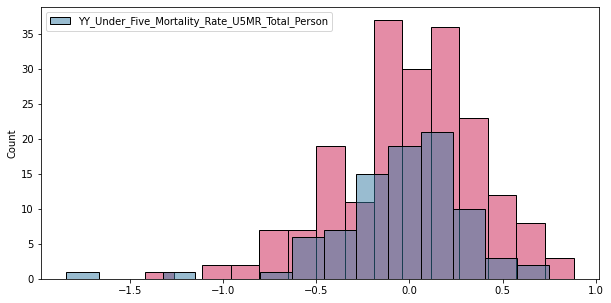

In [50]:
fig = plt.figure(figsize=(10, 5))

sns.histplot(y_train_pred-y_train, palette="rocket")
sns.histplot(y_test_pred-y_test, palette="mako")

#As with other models we have seen so far, there is a lot of overlap between
#the amount of error for the training and test subsets.

In [51]:
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# Unfortunately, R2 for the training subset is very slightly higher than that for the test subset,
# which indicates overfitting.

R^2 train: 0.858, test: 0.853


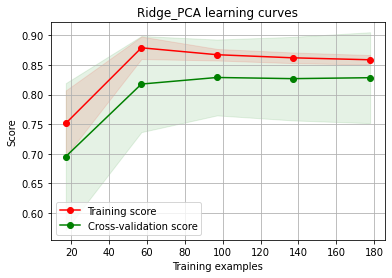

In [52]:
g = plot_learning_curve(gsRidge.best_estimator_,"Ridge_PCA learning curves", X_train_pca, y_train, cv=kfold)

#The scores are approaching each other, but they appear to be doing so less quickly than in the non-PCA Ridge model.
# Liek with the PCA Linear Regression model, the training score is rather low at first, but shoots up.

This model shows slight signs of overfitting in its R2 values and is not as good as the non-PCA Ridge model in both MSE and R2.

Gradient Boosting Regressor

In [53]:
model = GradientBoostingRegressor()

rs = RandomizedSearchCV(model, n_iter=10,
                        param_distributions = {"learning_rate": [0.01, 0.1],
                  "subsample": [0.9, 0.5, 0.1],
                  "n_estimators": [100,500,1000],
                  "max_depth": [3,6,10],
                 "loss": ["squared_error"]},
                        cv=5, n_jobs=-1, random_state=3,
                        scoring='explained_variance') 

rs.fit(X_train, y_train.values.ravel())

print(rs.best_params_)
print(rs.best_score_)

{'subsample': 0.9, 'n_estimators': 1000, 'max_depth': 3, 'loss': 'squared_error', 'learning_rate': 0.01}
0.8947565079854879


In [54]:
gbr = GradientBoostingRegressor(learning_rate=0.01, subsample=0.9, n_estimators=1000, max_depth=3, 
                               loss='squared_error', random_state=3)

gbr.fit(X_train, y_train.values.ravel())

GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000, random_state=3,
                          subsample=0.9)

In [55]:
y_train_pred = gbr.predict(X_train)
y_test_pred = gbr.predict(X_test)

In [56]:
print(list(zip(gbr.feature_importances_, X_train.columns)))

[(0.004508767963535567, 'AA_Population_Total'), (0.0036772167439089428, 'BB_Dependency_Ratio_Rural'), (0.003303282112524026, 'BB_Dependency_Ratio_Total'), (0.002615842189371817, 'BB_Dependency_Ratio_Urban'), (0.0035667230950597578, 'DD_Female_Total'), (0.019147808679461507, 'DD_Male_Total'), (0.003223141880708596, 'DD_Person_Rural'), (0.004093971850424822, 'DD_Person_Total'), (0.004234711991709708, 'DD_Person_Urban'), (0.0006283813174356241, 'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Rural'), (0.0016056975190057528, 'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Total'), (0.00706077042136382, 'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Urban'), (0.0040343727903987, 'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Rural'), (0.0037392457224203674, 'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Total'), (0.0016601279586426787, 'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Urban'), (0.021542528781001165, 'LL_Crude_Birth_Rate

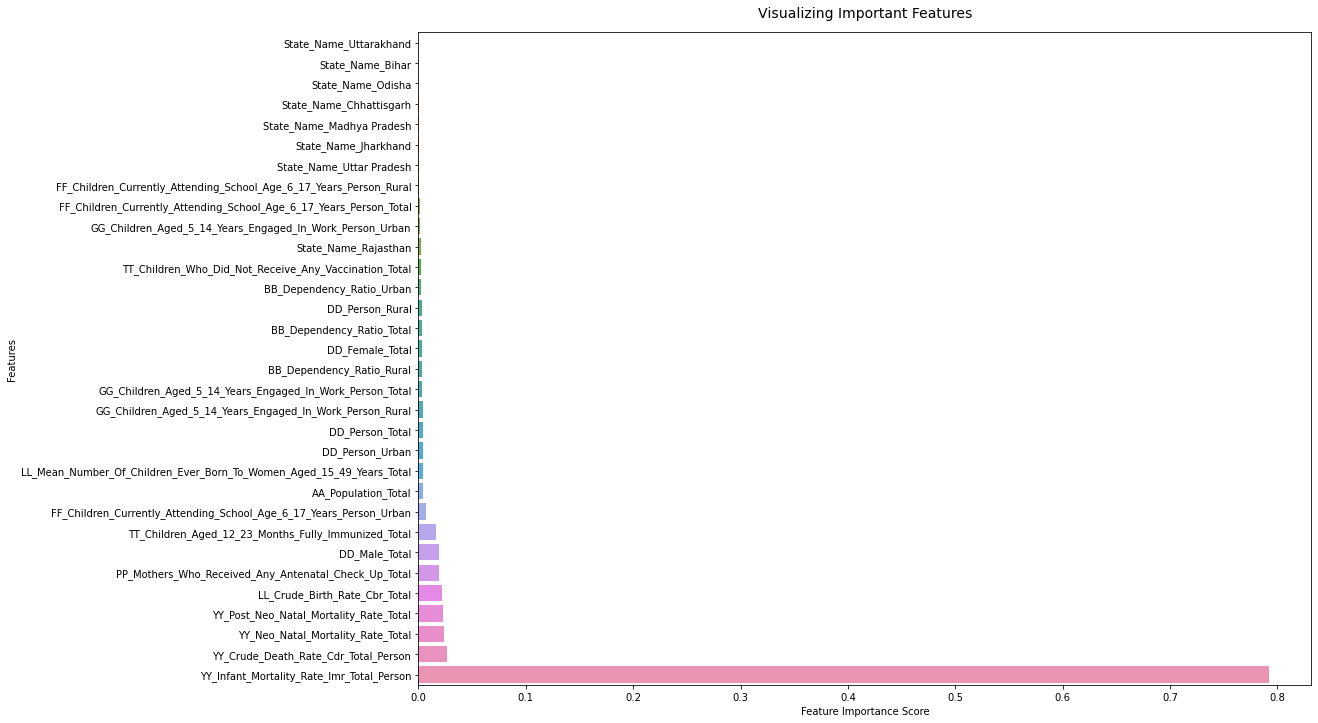

In [57]:
fig = plt.figure(figsize=(16, 12))


feature_imp = pd.Series(gbr.feature_importances_, index=['AA_Population_Total', 'BB_Dependency_Ratio_Rural', 
                                                        'BB_Dependency_Ratio_Total', 'BB_Dependency_Ratio_Urban', 
                                                        'DD_Female_Total', 'DD_Male_Total', 'DD_Person_Rural', 
                                                        'DD_Person_Total', 'DD_Person_Urban', 
                                                        'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Rural',
                                                        'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Total',
                                                        'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Urban',
                                                        'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Rural', 
                                                        'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Total', 
                                                        'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Urban', 
                                                        'LL_Crude_Birth_Rate_Cbr_Total', 
                                                        'LL_Mean_Number_Of_Children_Ever_Born_To_Women_Aged_15_49_Years_Total', 
                                                        'PP_Mothers_Who_Received_Any_Antenatal_Check_Up_Total', 
                                                        'TT_Children_Aged_12_23_Months_Fully_Immunized_Total', 
                                                        'TT_Children_Who_Did_Not_Receive_Any_Vaccination_Total', 
                                                        'YY_Crude_Death_Rate_Cdr_Total_Person', 
                                                        'YY_Infant_Mortality_Rate_Imr_Total_Person', 'YY_Neo_Natal_Mortality_Rate_Total',
                                                        'YY_Post_Neo_Natal_Mortality_Rate_Total', 'State_Name_Bihar', 
                                                        'State_Name_Chhattisgarh', 'State_Name_Jharkhand', 'State_Name_Madhya Pradesh', 
                                                        'State_Name_Odisha', 'State_Name_Rajasthan', 'State_Name_Uttar Pradesh', 
                                                        'State_Name_Uttarakhand']).sort_values(ascending=True)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", pad=15, size=14)
plt.savefig('Barplot.png')

Again, the four features related to death have the largest coefficients. By far, the variable with the greatest influence on the prediction is total Infant Mortality Rate. Therefore, this outcome is unsurprising and also may be a sign that the model is not very useful, since it is primarily based off of some very obvious predictors which would be addressed as part and parcel of addressing U5MR. They cannot be considered causes of U5MR.

In [58]:
print('Train mean squared error: %.3f' % mean_squared_error(y_true=y_train, y_pred=y_train_pred))

print('Test mean squared error: %.3f' % mean_squared_error(y_true=y_test, y_pred=y_test_pred))

#Test MSE is enormous compared to train MSE. This is not at all promising.
#Notably, the train error is close to 0%, which indicates that nearly all predicted values were close to the actual ones.
#Rather than being a good thing, this may also be a sign of overfitting.

Train mean squared error: 0.006
Test mean squared error: 0.116


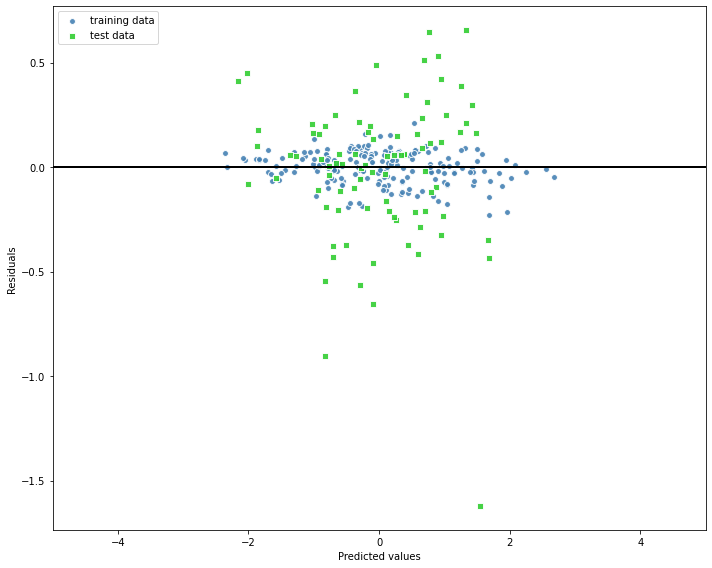

In [59]:
y_train_pred=y_train_pred.reshape(198,1)
y_test_pred=y_test_pred.reshape(86,1)

fig = plt.figure(figsize=(10, 8))

plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-5, 5])
plt.tight_layout()

plt.show()

#We can clearly see from their proximity to the black line that the training data residuals are quite low,
# whereas the test data residuals are much further out, illustrating their much higher MSE.

<AxesSubplot:ylabel='Count'>

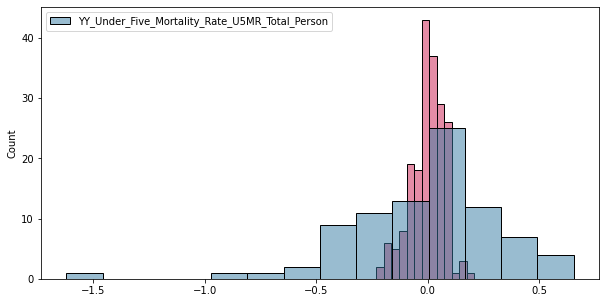

In [60]:
fig = plt.figure(figsize=(10, 5))

sns.histplot(y_train_pred-y_train, palette="rocket")
sns.histplot(y_test_pred-y_test, palette="mako")

#Unlike in plots of error for the other models that we have seen so far,
# here the error for the test data is much greater overall than that for the training data.

In [61]:
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

#R2 for the training subset is much higher than for the test subset. This is not good.
#Additionally, it is notable that the training R2 is nearly 100%. This may also indicate overfitting.

R^2 train: 0.994, test: 0.879


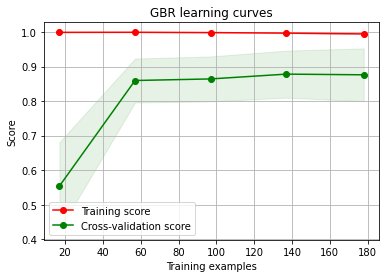

In [62]:
g = plot_learning_curve(gsGBR.best_estimator_,"GBR learning curves", X_train, y_train, cv=kfold)

#In keeping with what we saw from MSE and R2, the training score is almost 100% throughout.
#It does not approach the cross-validation score at all. This indicates overfitting.

The gradient boosting regressor model is not at all good. It is highly overfit, indicated by its training values for MSE and R2 showing almost a complete match between predicted and actual values, which is not replicated for the test set.

Gradient Boosting Regressor with PCA

In [63]:
gsGBR.fit(X_train_pca,y_train.values.ravel())

GBR_best_pca = gsGBR.best_estimator_

gsGBR.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8285254045277537

In [64]:
rs_pca = RandomizedSearchCV(model, n_iter=10,
                        param_distributions = {"learning_rate": [0.01, 0.1],
                  "subsample": [0.9, 0.5, 0.1],
                  "n_estimators": [100,500,1000],
                  "max_depth": [3,6,10],
                 "loss": ["squared_error"]},
                        cv=5, n_jobs=-1, random_state=3,
                        scoring='explained_variance')

rs_pca.fit(X_train_pca, y_train.values.ravel())

print(rs.best_params_)
print(rs.best_score_)

{'subsample': 0.9, 'n_estimators': 1000, 'max_depth': 3, 'loss': 'squared_error', 'learning_rate': 0.01}
0.8947565079854879


In [65]:
gbr_pca = GradientBoostingRegressor(learning_rate=0.01, subsample=0.9, n_estimators=1000, max_depth=3, 
                               loss='squared_error', random_state=3)

gbr_pca.fit(X_train_pca, y_train.values.ravel())

GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000, random_state=3,
                          subsample=0.9)

In [66]:
y_train_pred = gbr_pca.predict(X_train_pca)
y_test_pred = gbr_pca.predict(X_test_pca)

In [67]:
print(list(zip(gbr_pca.feature_importances_, pca.components_)))

#All of the eigenvalues are positive here, which is good.

[(0.398071866526577, array([-0.12092586,  0.23589636,  0.24414177,  0.1952839 , -0.28294407,
       -0.27599034, -0.26700291, -0.28790038, -0.24896063, -0.12834882,
       -0.13972701, -0.10132941,  0.13395978,  0.14528611,  0.10075802,
        0.24343827,  0.22471701, -0.23696114, -0.19746042,  0.22679493,
        0.11645935,  0.19498251,  0.1778735 ,  0.14078899,  0.02263532,
       -0.01745975, -0.00602909, -0.00903027, -0.0183463 ,  0.01199843,
        0.05445957, -0.01928863])), (0.22037966939957906, array([ 0.15590994,  0.27379634,  0.27439601,  0.27714915, -0.09806938,
       -0.07040997, -0.07766804, -0.09129401, -0.11039057,  0.3329423 ,
        0.33458104,  0.28482048, -0.19049194, -0.20009364, -0.21562418,
        0.07852223,  0.1243702 , -0.12990005,  0.14675492, -0.01264384,
       -0.2127575 , -0.25355369, -0.22794742, -0.18622199,  0.12326305,
        0.00549506,  0.03413856, -0.03598613, -0.06508504, -0.0058534 ,
       -0.04545188,  0.01842254])), (0.26749975832024575,

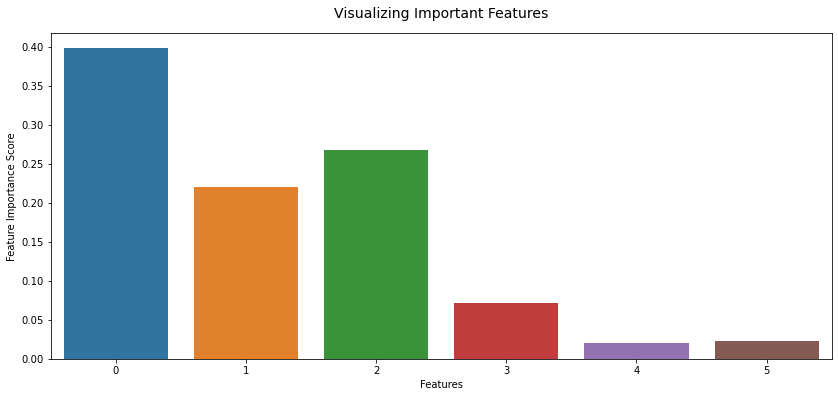

In [68]:
fig = plt.figure(figsize=(14, 6))

feature_imp = pd.Series(gbr_pca.feature_importances_).sort_values(ascending=True)

sns.barplot(x=feature_imp.index, y=feature_imp)
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.title("Visualizing Important Features", pad=15, size=14)
plt.savefig('Barplot.png')

Compared to the Gradient Boosting Regressor model that utilized all features, overall the feature importance when using PCA is less dominated by a single component. In fact, in the non-PCA model, the highest feature importance score was close to 0.80, whereas in this model, the highest score is close to 0.40. This discrepancy is magnified when considering that the non-PCA model contained 32 features among which the feature importance was split, whereas this model has only six components.

In [69]:
print('Train mean squared error: %.3f' % mean_squared_error(y_true=y_train, y_pred=y_train_pred))

print('Test mean squared error: %.3f' % mean_squared_error(y_true=y_test, y_pred=y_test_pred))

#As with the GBR model that utilized all features, here the train MSE is also much lower than the test MSE.
#The train MSE is slightly further from 0%, but this is still not good.

Train mean squared error: 0.017
Test mean squared error: 0.193


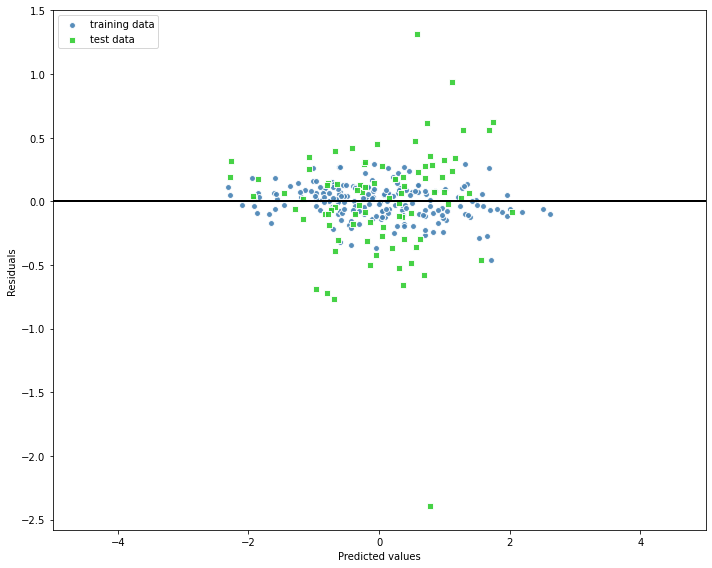

In [70]:
y_train_pred=y_train_pred.reshape(198,1)
y_test_pred=y_test_pred.reshape(86,1)

fig = plt.figure(figsize=(10, 8))

plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-5, 5])
plt.tight_layout()

plt.show()

#Again, the training data residuals are concentrated close to the black line, which would be good on its own,
# but is very bad and a sure sign of overfitting when concentrated with the test data residuals.

<AxesSubplot:ylabel='Count'>

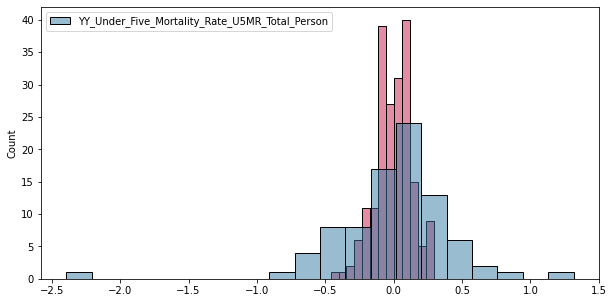

In [71]:
fig = plt.figure(figsize=(10, 5))

sns.histplot(y_train_pred-y_train, palette="rocket")
sns.histplot(y_test_pred-y_test, palette="mako")

#As with the non-PCA Gradient Boosting Regressor model, the test error is much more widely dispersed than the training error

In [72]:
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

#The training R2 is again much higher than the test R2. This indicates overfitting.
#Similar to what we saw with MSE for this model, the R2 is a little further from 100% than it was
#for the GBR model that utilized all predictors.

R^2 train: 0.983, test: 0.799


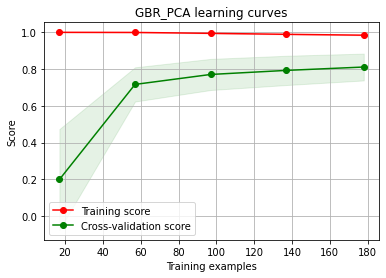

In [73]:
g = plot_learning_curve(gsGBR.best_estimator_,"GBR_PCA learning curves", X_train_pca, y_train, cv=kfold)

#Again, the training score barely approaches the cross-validation score, but we note that
# the cross-validation score here ends up lower in the PCA GBR model than in the non-PCA GBR model, which is not good.

The gradient boosting regressor with PCA is also highly overfit, and does worse than the non-PCA gradient boosting regressor across MSE, R2 and the learning curve. It may be unsurprising that both GBR models performed poorly, as they are tree-based. Particularly with a dataset as highly dimensional as the one we are working with, even if through principal components, tree-based models are not always suited to predicting continuous variables.

Random Forest Regressor

In [74]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

rs = RandomizedSearchCV(model, n_iter=10,
                        param_distributions = {"max_depth": [None],
              "max_features": [1, 3, 10, 20],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100],
              "criterion": ["squared_error"]},
                        cv=5, n_jobs=-1, random_state=3,
                        scoring='explained_variance')

rs.fit(X_train, y_train.values.ravel())

print(rs.best_params_)
print(rs.best_score_)

{'n_estimators': 100, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': None, 'criterion': 'squared_error', 'bootstrap': False}
0.8822866735051003


In [75]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_leaf=3, 
                           max_features=10, criterion='squared_error', bootstrap=False, random_state=3)

rfr.fit(X_train, y_train.values.ravel())

RandomForestRegressor(bootstrap=False, max_features=10, min_samples_leaf=3,
                      random_state=3)

In [76]:
y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)

In [77]:
print(list(zip(rfr.feature_importances_, X_train.columns)))

[(0.007571170420857129, 'AA_Population_Total'), (0.0047301299684716115, 'BB_Dependency_Ratio_Rural'), (0.004858604882926549, 'BB_Dependency_Ratio_Total'), (0.00512936241392995, 'BB_Dependency_Ratio_Urban'), (0.00845857075467949, 'DD_Female_Total'), (0.011720739320778816, 'DD_Male_Total'), (0.0062274515100164, 'DD_Person_Rural'), (0.013264211904543528, 'DD_Person_Total'), (0.003366311251989897, 'DD_Person_Urban'), (0.0031915612319083743, 'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Rural'), (0.0035188815624247324, 'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Total'), (0.003886975119533615, 'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Urban'), (0.005624573754272085, 'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Rural'), (0.005997095197939612, 'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Total'), (0.0038240372363177017, 'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Urban'), (0.037406465774999786, 'LL_Crude_Birth_Rate_Cb

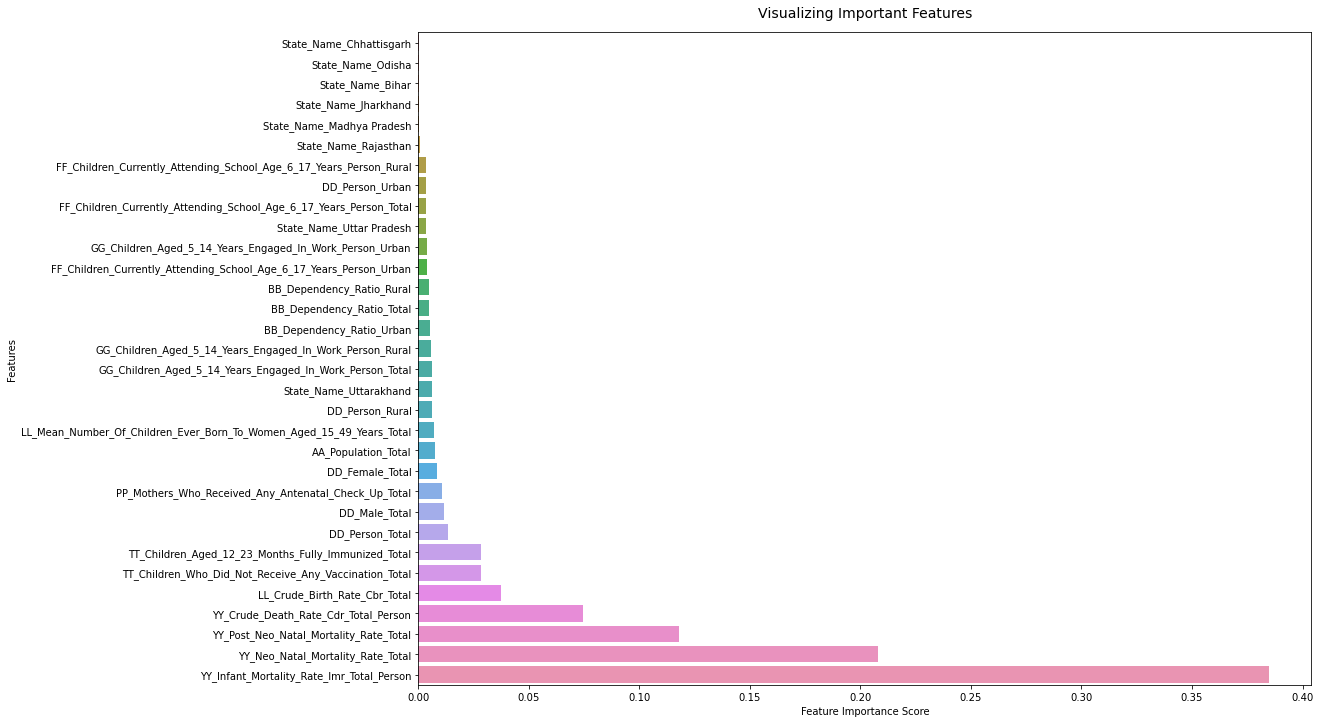

In [78]:
fig = plt.figure(figsize=(16, 12))


feature_imp = pd.Series(rfr.feature_importances_, index=['AA_Population_Total', 'BB_Dependency_Ratio_Rural', 
                                                        'BB_Dependency_Ratio_Total', 'BB_Dependency_Ratio_Urban', 
                                                        'DD_Female_Total', 'DD_Male_Total', 'DD_Person_Rural', 
                                                        'DD_Person_Total', 'DD_Person_Urban', 
                                                        'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Rural',
                                                        'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Total',
                                                        'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Urban',
                                                        'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Rural', 
                                                        'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Total', 
                                                        'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Urban', 
                                                        'LL_Crude_Birth_Rate_Cbr_Total', 
                                                        'LL_Mean_Number_Of_Children_Ever_Born_To_Women_Aged_15_49_Years_Total', 
                                                        'PP_Mothers_Who_Received_Any_Antenatal_Check_Up_Total', 
                                                        'TT_Children_Aged_12_23_Months_Fully_Immunized_Total', 
                                                        'TT_Children_Who_Did_Not_Receive_Any_Vaccination_Total', 
                                                        'YY_Crude_Death_Rate_Cdr_Total_Person', 
                                                        'YY_Infant_Mortality_Rate_Imr_Total_Person', 'YY_Neo_Natal_Mortality_Rate_Total',
                                                        'YY_Post_Neo_Natal_Mortality_Rate_Total', 'State_Name_Bihar', 
                                                        'State_Name_Chhattisgarh', 'State_Name_Jharkhand', 'State_Name_Madhya Pradesh', 
                                                        'State_Name_Odisha', 'State_Name_Rajasthan', 'State_Name_Uttar Pradesh', 
                                                        'State_Name_Uttarakhand']).sort_values(ascending=True)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", pad=15, size=14)
plt.savefig('Barplot.png')

We see that the four most important features, which have the greatest effect on the predictive model, are the four that also are related to mortality/death rates. We had anticipated prior to modeling that these would be closely correlated to the target. Therefore, this is unsurprising and also may be a sign that the model is not very useful, since it is primarily based off of some very obvious predictors which would anyway be addressed as part and parcel of addressing U5MR. They cannot be considered causes of U5MR.

State feature importances are interesting here. Uttarakhand, which has the least number of districts (13), has the highest importance. Uttar Pradesh, which has the most districts (70) has the second-most importance. So there is no correlation between number of samples associated with a state and its feature importance. Additionally, we recall that one state (Assam) was dropped from the data set when we made our categorical state variable into binary dummy variables. Its feature importance is not shown here.

In [79]:
print('Train mean squared error: %.3f' % mean_squared_error(y_true=y_train, y_pred=y_train_pred))

print('Test mean squared error: %.3f' % mean_squared_error(y_true=y_test, y_pred=y_test_pred))

#This model is clearly overfit, as the test MSE is much higher than the training MSE.

Train mean squared error: 0.010
Test mean squared error: 0.149


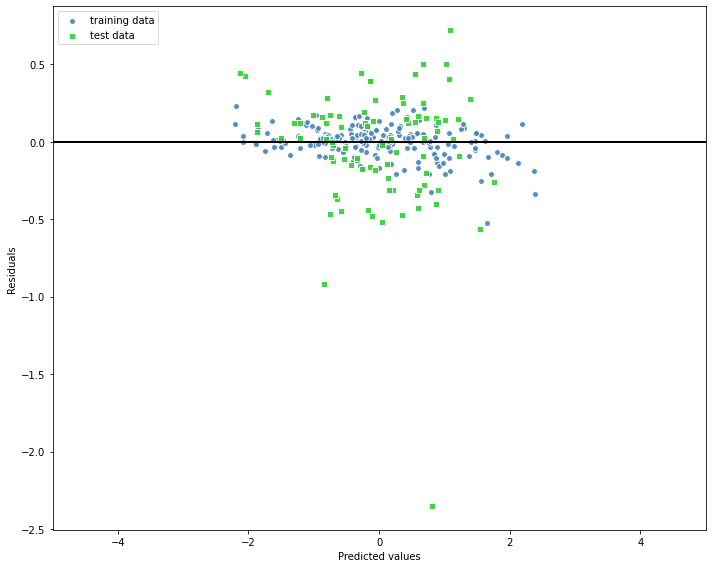

In [80]:
y_train_pred=y_train_pred.reshape(198,1)
y_test_pred=y_test_pred.reshape(86,1)

fig = plt.figure(figsize=(10, 8))

plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-5, 5])
plt.tight_layout()

plt.show()

#We see that the training residuals are generally low, and the test residuals are generally much higher.

<AxesSubplot:ylabel='Count'>

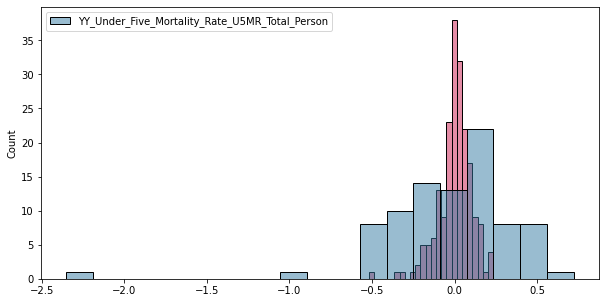

In [81]:
fig = plt.figure(figsize=(10, 5))

sns.histplot(y_train_pred-y_train, palette="rocket")
sns.histplot(y_test_pred-y_test, palette="mako")

#Of course, the test error is greater overall and more widely dispersed than the training error.

In [82]:
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# Test R2 is much lower than train R2, which again indicates overfitting.

R^2 train: 0.990, test: 0.845


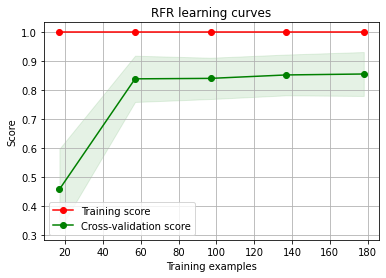

In [83]:
g = plot_learning_curve(gsRFR.best_estimator_,"RFR learning curves", X_train, y_train, cv=kfold)


#This also shows signs of overfitting - the training score never approaches the cross-validation score.
# The latter appears to increase with the addition of more training samples until a point at which it plateaus.

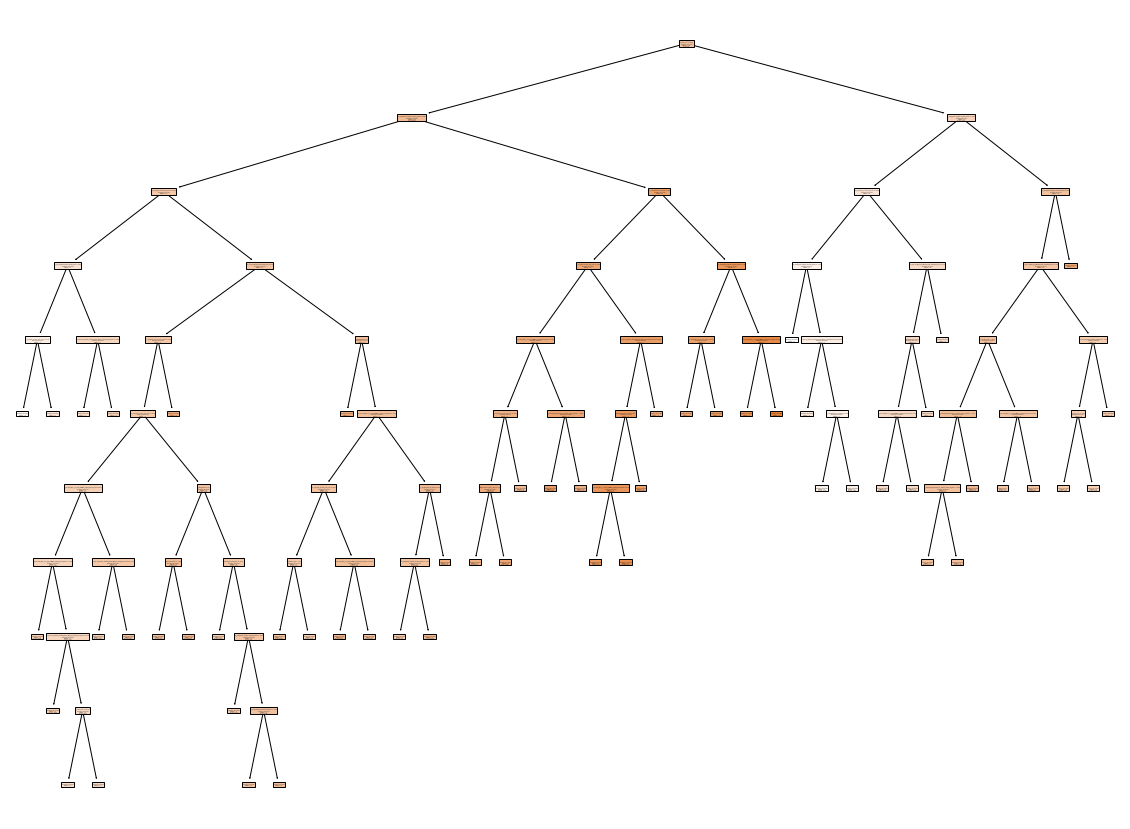

In [84]:
#Here, we see one of the trees from the 100 that comprise this random forest.

from sklearn import tree
fig = plt.figure(figsize=(20, 15))
_ = tree.plot_tree(rfr.estimators_[0], feature_names=X_train.columns, filled=True)

In [85]:
rfr.estimators_[0].tree_.max_depth

#The tree above has depth of ten levels, too many too see anything.
#A data point may have been redirected up to ten times based on its feature values
# before a prediction was made on its target value.

10

The basic Random Forest Regressor is very poor and is shown to be highly overfit by both its R2 and its MSE.

In [86]:
#We willl train the forest again with max_depth 3 just for illustrative purposes, even though we have better,
# ideal hyperparameters. This is only so that we can examine a tree, not use the model.

rfr3 = RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_leaf=3, 
                           max_features=10, criterion='squared_error', bootstrap=False, random_state=3)

rfr3.fit(X_train, y_train.values.ravel())

RandomForestRegressor(bootstrap=False, max_depth=3, max_features=10,
                      min_samples_leaf=3, random_state=3)

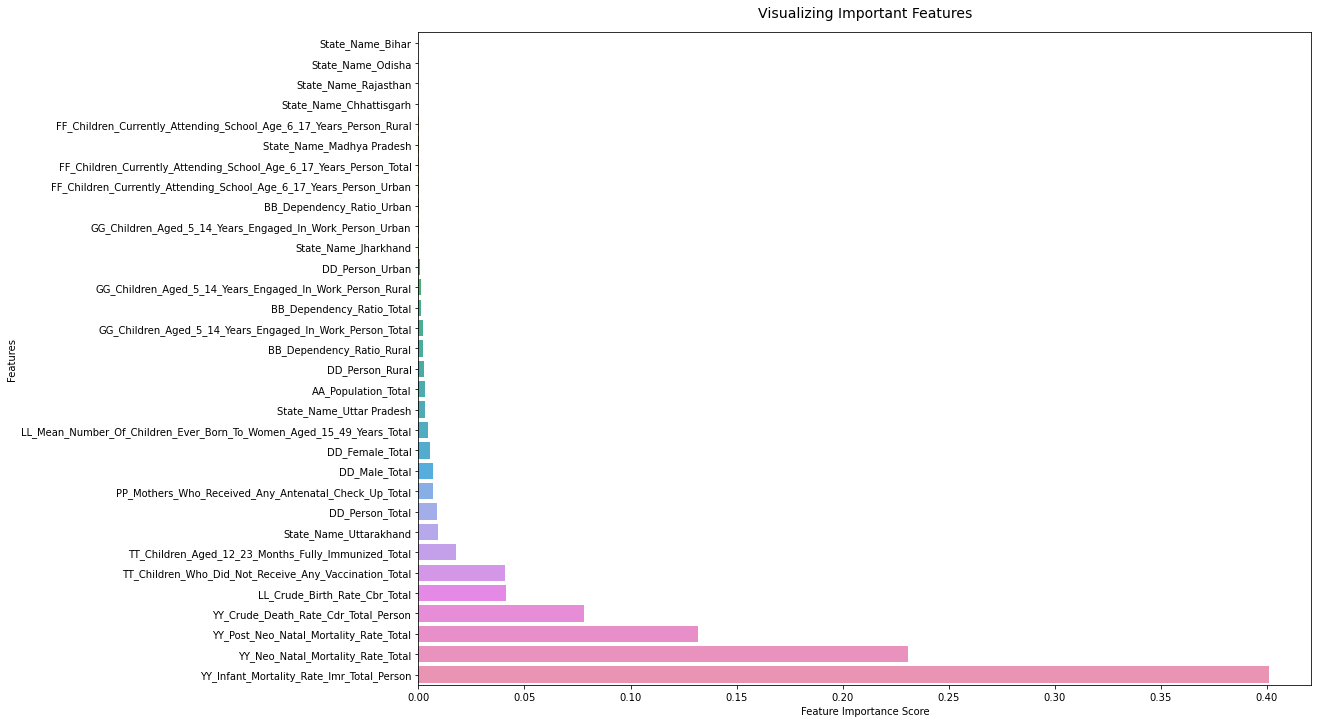

In [87]:
fig = plt.figure(figsize=(16, 12))


feature_imp = pd.Series(rfr3.feature_importances_, index=['AA_Population_Total', 'BB_Dependency_Ratio_Rural', 
                                                        'BB_Dependency_Ratio_Total', 'BB_Dependency_Ratio_Urban', 
                                                        'DD_Female_Total', 'DD_Male_Total', 'DD_Person_Rural', 
                                                        'DD_Person_Total', 'DD_Person_Urban', 
                                                        'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Rural',
                                                        'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Total',
                                                        'FF_Children_Currently_Attending_School_Age_6_17_Years_Person_Urban',
                                                        'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Rural', 
                                                        'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Total', 
                                                        'GG_Children_Aged_5_14_Years_Engaged_In_Work_Person_Urban', 
                                                        'LL_Crude_Birth_Rate_Cbr_Total', 
                                                        'LL_Mean_Number_Of_Children_Ever_Born_To_Women_Aged_15_49_Years_Total', 
                                                        'PP_Mothers_Who_Received_Any_Antenatal_Check_Up_Total', 
                                                        'TT_Children_Aged_12_23_Months_Fully_Immunized_Total', 
                                                        'TT_Children_Who_Did_Not_Receive_Any_Vaccination_Total', 
                                                        'YY_Crude_Death_Rate_Cdr_Total_Person', 
                                                        'YY_Infant_Mortality_Rate_Imr_Total_Person', 'YY_Neo_Natal_Mortality_Rate_Total',
                                                        'YY_Post_Neo_Natal_Mortality_Rate_Total', 'State_Name_Bihar', 
                                                        'State_Name_Chhattisgarh', 'State_Name_Jharkhand', 'State_Name_Madhya Pradesh', 
                                                        'State_Name_Odisha', 'State_Name_Rajasthan', 'State_Name_Uttar Pradesh', 
                                                        'State_Name_Uttarakhand']).sort_values(ascending=True)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features", pad=15, size=14)
plt.savefig('Barplot.png')


#We can also see that, by changing max_depth, the feature importances slightly changed in both amount and order.

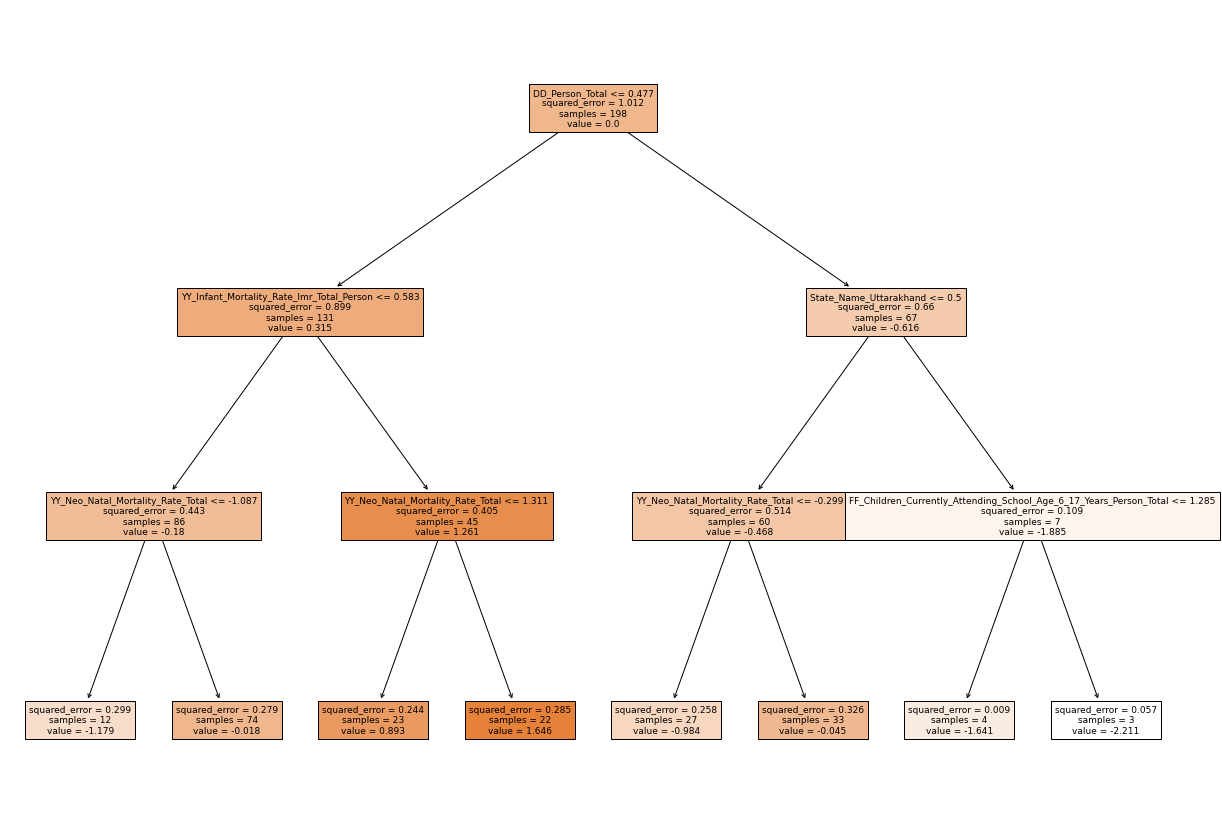

In [88]:
from sklearn import tree
fig = plt.figure(figsize=(21, 15))
_ = tree.plot_tree(rfr3.estimators_[0], feature_names=X_train.columns, filled=True, fontsize=9)

Here, we can clearly see the basis on which predictions are made, using one singular tree from the random forest of 100 trees (whose predictions would be averaged for each data point). Given that there are only eight possible target predictions for this tree, it is very likely that a random forest with a depth of three levels would be an even worse regressor than the one we created with ideal hyperparameters.

Again, this Random Forest Regressor was created solely so that we could visually inspect one of its trees, not to use as a predictive model. Therefore, we will not examine its performance metrics further.

Random Forest Regressor with PCA

In [89]:
gsRFR.fit(X_train_pca,y_train.values.ravel())

RFR_best_pca = gsRFR.best_estimator_

gsRFR.best_score_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


0.7605567916912104

In [90]:
rs_pca = RandomizedSearchCV(model, n_iter=10,
                        param_distributions = {"max_depth": [None],
              "max_features": [1, 3, 10, 20],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100],
              "criterion": ["squared_error"]},
                        cv=5, n_jobs=-1, random_state=3,
                        scoring='explained_variance')

rs_pca.fit(X_train_pca, y_train.values.ravel())

print(rs.best_params_)
print(rs.best_score_)

{'n_estimators': 100, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': None, 'criterion': 'squared_error', 'bootstrap': False}
0.8822866735051003


In [91]:
rfr_pca = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_leaf=1, 
                           max_features=3, criterion='squared_error', bootstrap=False, random_state=3)

rfr_pca.fit(X_train_pca, y_train.values.ravel())

RandomForestRegressor(bootstrap=False, max_features=3, random_state=3)

In [92]:
y_train_pred = rfr_pca.predict(X_train_pca)
y_test_pred = rfr_pca.predict(X_test_pca)

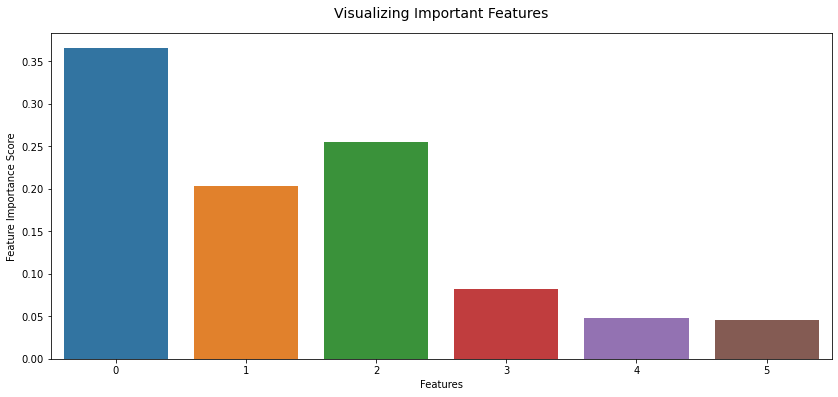

In [93]:
fig = plt.figure(figsize=(14, 6))

feature_imp = pd.Series(rfr_pca.feature_importances_).sort_values(ascending=True)

sns.barplot(x=feature_imp.index, y=feature_imp)
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.title("Visualizing Important Features", pad=15, size=14)
plt.savefig('Barplot.png')

#Compared to the random forest model that utilized all predictors,
#here,there is somewhat less disparity between the feature importance of the six largest principal components.

In [94]:
print('Train mean squared error: %.3f' % mean_squared_error(y_true=y_train, y_pred=y_train_pred))

print('Test mean squared error: %.3f' % mean_squared_error(y_true=y_test, y_pred=y_test_pred))

#The test MSE is massively greater than the train MSE, which is exactly 0%. This is a sure sign of overfitting.

Train mean squared error: 0.000
Test mean squared error: 0.235


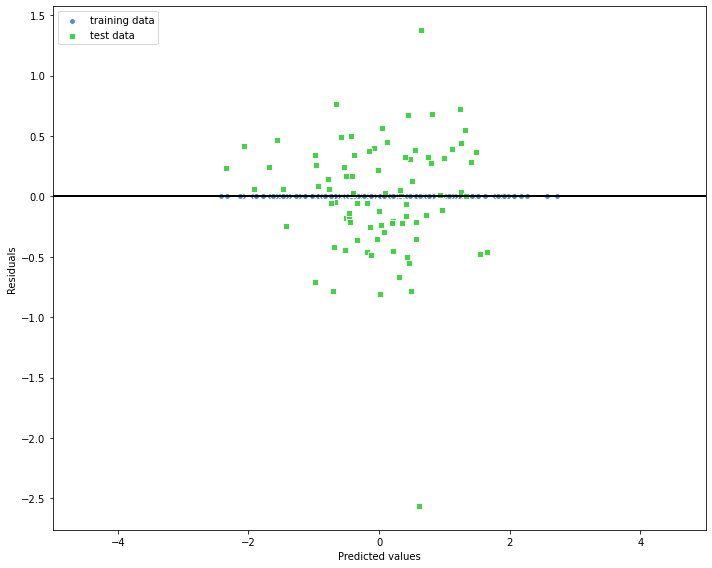

In [95]:
y_train_pred=y_train_pred.reshape(198,1)
y_test_pred=y_test_pred.reshape(86,1)

fig = plt.figure(figsize=(10, 8))

plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-5, 5])
plt.tight_layout()

plt.show()

#We can see that the training values are all on the black line, a sign of low error.
#Normally, this would be desirable, but is not when contrasted with the enormous residuals that most of the test data have.

<AxesSubplot:ylabel='Count'>

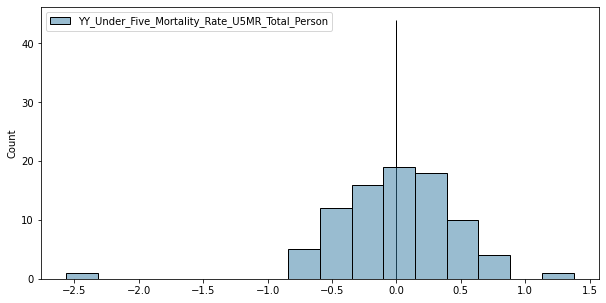

In [96]:
fig = plt.figure(figsize=(10, 5))

sns.histplot(y_train_pred-y_train, palette="rocket")
sns.histplot(y_test_pred-y_test, palette="mako")

#We can see that only the error of the test data (blue) shows appears as bars since the training data has no error.

In [97]:
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

#Here, the test R2 is much lower than the train R2, which is 100%. Again, this indicates overfitting.

R^2 train: 1.000, test: 0.755


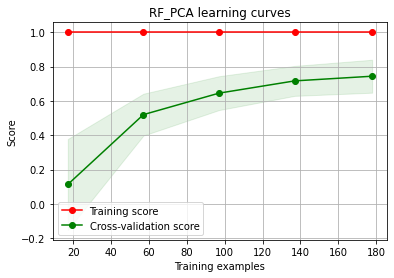

In [98]:
g = plot_learning_curve(gsRFR.best_estimator_,"RF_PCA learning curves", X_train_pca, y_train, cv=kfold)

Like in the non-PCA RF learning curve, here, the training score does not move from 100%, which is not good. However, the cross-validation score approaches the training score and does not seem to plateau. The cross-validation score for the RF model that utilized all features was higher than that found here. Overall, this learning curve is not promising.

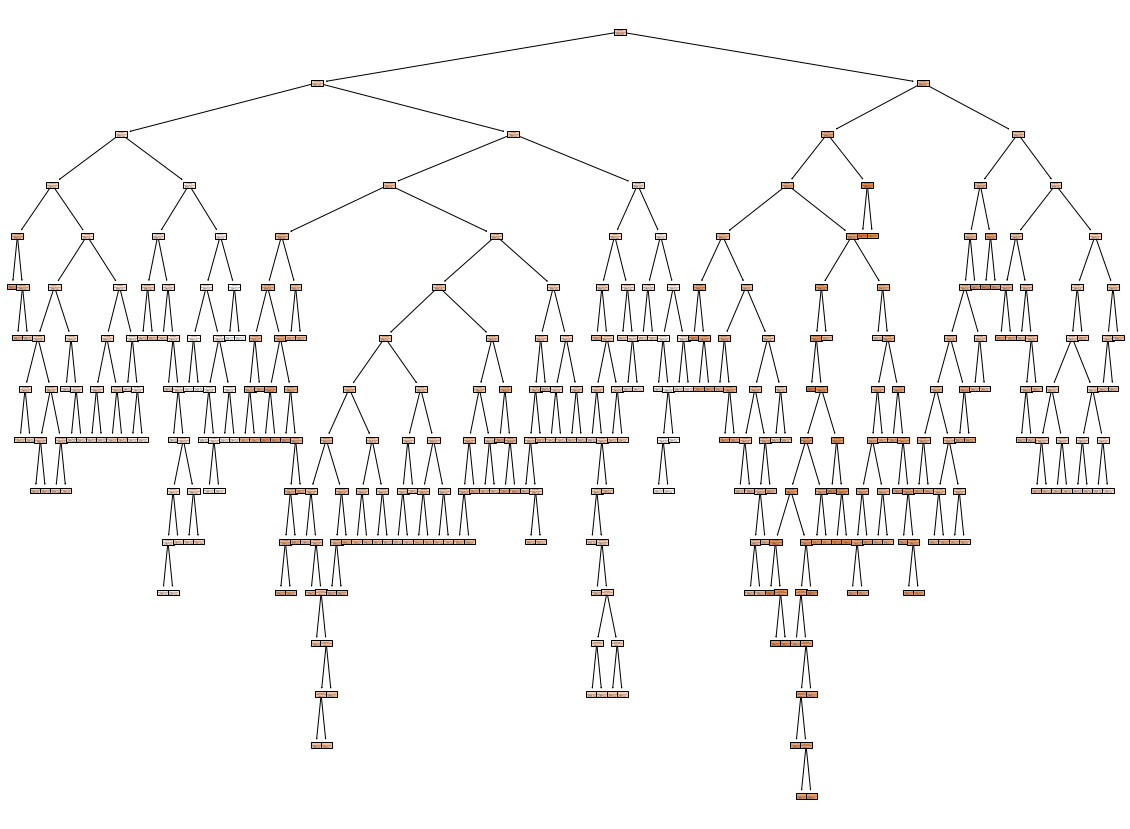

In [99]:
#We see one tree from our random forest that contains 100 decision trees total.

from sklearn import tree
fig = plt.figure(figsize=(20, 15))
X_train_pca = pd.DataFrame(X_train_pca)
_ = tree.plot_tree(rfr_pca.estimators_[0], feature_names=X_train_pca.columns, filled=True)

In [100]:
rfr_pca.estimators_[0].tree_.max_depth

#This tree above has depth of 15 levels, too many too see anything.

15

This is the worst model created. Its MSE and R2 values reveal that it is extremely overfit and are worse than those of all other models.

Since we have two models that performed particularly well in evaluation metrics including MSE, R2 and the learning curves and provided other useful information such as coefficients, we will combine them, non-PCA Linear Regression and non-PCA Ridge Regression, into an ensemble regressor that averages the predictions from both to output a single prediction. In the correlation matrix below, we see that there is a 100% correlation between the predictions made by each individual model, so creating an ensemble only strengthens the prediction that either would have made. This will be the final model that we recommend using to predict the Under-Five Mortality Rate in the nine states where the Annual Health Survey took place.

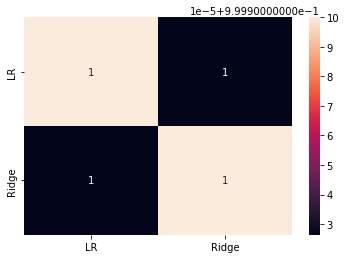

In [101]:
#We make Series of the test subset predictions from the two best models
#and use a correlation matrix to see how much overlap there is.

test_LR = pd.Series(LR_best.predict(X_test), name="LR")
test_Ridge = pd.Series(Ridge_best.predict(X_test), name="Ridge")


# Concatenate all regressor results
ensemble_results = pd.concat([test_LR,test_Ridge],axis=1)

g=sns.heatmap(ensemble_results.corr(),annot=True)

In [102]:
#Create a voting regressor that averages the predictions of the two best models

votingR = VotingRegressor(estimators=[('LR', LR_best), ('Ridge', Ridge_best)], n_jobs=-1)

votingR = votingR.fit(X_train, y_train.values.ravel())

In [103]:
#Save the predictions to a CSV
test_U5MR = pd.Series(votingR.predict(X_test), name="U5MR")

index=pd.Series(X_test.index)
results = pd.Series(test_U5MR)

results_file=pd.concat([index, results],axis=1)
results_file.to_csv("ensemble_python_voting.csv",index=False)